## 0 Imports & load data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If df is already in memory you can skip this read:
DF_PATH = "ocean_out/telemetry_with_era5_ocean_density.parquet"
df = pd.read_parquet(DF_PATH)


## 1 Calculating wind and current variables

In [21]:
df["wind_speed_10m_ms"] = np.sqrt(df["u10"]**2 + df["v10"]**2)
df["wind_dir_10m"] = np.degrees(np.arctan2(df["u10"], df["v10"]))
df["wind_dir_10m"] = (df["wind_dir_10m"] + 360) % 360
df["current_speed_ms"] = np.sqrt(df["uo"]**2 + df["vo"]**2)
df["current_dir"] = np.degrees(np.arctan2(df["uo"], df["vo"]))
df["current_dir"] = (df["current_dir"] + 360) % 360
df["HeadingTrue_deg_360"] = (df["HeadingTrue_deg"] + 360) % 360
df["WindAngleRelative_deg"] = (df["WindAngleRelative_deg"] + 360) % 360

# Ensure timestamp is datetime and sorted
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

## 2 Removing rows with NaN for critical collumns and fill for draugth columns

In [22]:
# --- Ensure timestamp exists as a column ---
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values("timestamp")

# Interpolate drafts using timestamp as index
draft_cols = ["Draught_A_m", "Draught_F_m"]

df = df.set_index("timestamp")
df[draft_cols] = df[draft_cols].interpolate(method="time")
df = df.reset_index()   # bring timestamp back

# Critical columns
CRITICAL_COLS = [
    "timestamp",
    "Latitude_deg",
    "Longitude_deg",
    "SpeedThroughWater_kn",
    "SpeedOverGround_kn",
    "ShaftPower_kW",
    "ShaftRev_rpm",
    "Draught_A_m",
    "Draught_F_m",
    "u10", "v10",
    "uo", "vo",
    "thetao", "so", "rho_surface",
    "swh", "mwp", "mwd",'wind_speed_10m_ms',
    'wind_dir_10m','wind_dir_10m','current_speed_ms','current_dir',
    'HeadingTrue_deg_360','WindAngleRelative_deg'


]

print("Before filtering:", len(df))

# Remove rows missing critical values
df = df.dropna(subset=CRITICAL_COLS).reset_index(drop=True)

print("After filtering :", len(df))
print("Rows removed    :", len(df))



Before filtering: 780345
After filtering : 736212
Rows removed    : 736212


In [23]:
df = df.drop(columns=['draft_fwd', 'draft_aft', 'goodwx', 'u10', 'v10', 'vo', 'uo', 'WindAngleRelative_deg', 'WindSpeedRelative_m_s'])

## 3 Removing values outside threshold values

In [24]:
def remove_threashold_values(df):
    
    MIN_POWER_KW   = 500        # keep ≤ 3800 kW
    MIN_RPM        = 40
    MIN_STW        = 5         # kn, remove "stopped" / junk STW
    MAX_SWH        = 6.0         # m, clip extreme storms if wanted
    df_clean = df[df["ShaftPower_kW"]>MIN_POWER_KW]
    print(df_clean.shape)
    df_clean = df_clean[df_clean["ShaftRev_rpm"]>MIN_RPM]
    print(df_clean.shape)
    df_clean = df_clean[df_clean["SpeedThroughWater_kn"]>MIN_STW ]
    print(df_clean.shape)
    df_clean = df_clean[df_clean["swh"]<MAX_SWH]
    return df_clean

df = remove_threashold_values(df)

(704855, 25)
(698643, 25)
(698207, 25)


## 4 Removing points where heading varies more than the STD in 30 min time window

In [25]:
def filter_heading_std(df, heading_col='heading', window_minutes=30, std_threshold=0.6):
    """
    Filters rows based on circular rolling standard deviation of heading.
    Output has the same columns as the input.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with 1-minute sampling.
    heading_col : str
        Name of the heading column.
    window_minutes : int
        Rolling window size in minutes (default = 30).
    std_threshold : float
        Maximum allowed circular std deviation in degrees.

    Returns
    -------
    pd.DataFrame
        Filtered dataframe with same columns.
    """

    # Convert heading to radians
    headings_rad = np.deg2rad(df[heading_col])

    # Precompute sine & cosine
    sin_h = np.sin(headings_rad)
    cos_h = np.cos(headings_rad)

    # Rolling mean of sine and cosine
    sin_mean = sin_h.rolling(window_minutes).mean()
    cos_mean = cos_h.rolling(window_minutes).mean()

    # Circular variance formula
    R = np.sqrt(sin_mean**2 + cos_mean**2)

    # Circular standard deviation in radians
    circ_std_rad = np.sqrt(-2 * np.log(R))

    # Convert to degrees
    circ_std_deg = np.rad2deg(circ_std_rad)

    # Filter mask
    mask = circ_std_deg <= std_threshold

    # Return filtered df (same columns)
    return df[mask].copy()

df = filter_heading_std(df, heading_col='HeadingTrue_deg', window_minutes=10, std_threshold=0.6)

## 5 Eliminating data with big variance in shaft reveloutions

In [26]:
def filter_rpm_std(df, rpm_col='shaft_rpm', window_minutes=10, std_threshold=0.4):
    """
    Removes rows where the rolling standard deviation of shaft RPM
    indicates acceleration or deceleration. Output has the SAME columns.

    Parameters
    ----------
    df : pd.DataFrame
        1-minute sampled data.
    rpm_col : str
        Name of the shaft RPM column.
    window_minutes : int
        Rolling window size in minutes (default=10).
    std_threshold : float
        Max allowed rpm std before row is removed.

    Returns
    -------
    pd.DataFrame
        Filtered dataframe, same columns as input.
    """
    
    # compute rolling std without modifying the original df
    rpm_std = df[rpm_col].rolling(window=window_minutes).std()
    
    # identify steady periods
    mask = rpm_std <= std_threshold
    
    # return filtered df, same columns only
    return df[mask].copy()

df = filter_rpm_std(df, rpm_col='ShaftRev_rpm', window_minutes=10, std_threshold=0.4)

In [27]:
def smooth_columns(df, cols, window_med=3, window_mean=5):
    """
    Apply light smoothing to reduce sensor noise:
    1) Rolling median removes spikes
    2) Rolling mean smooths residual noise
    
    Assumes 1-minute data resolution.
    """
    df = df.copy()
    
    for col in cols:
        if col not in df:
            continue
        
        # Step 1: remove spikes
        med = df[col].rolling(window_med, center=True, min_periods=1).median()
        
        # Step 2: smooth remaining noise
        smoothed = med.rolling(window_mean, center=True, min_periods=1).mean()
        
        df[col + "_smooth"] = smoothed
        
    return df

SMOOTH_COLS = [
    "ShaftPower_kW",
    "ShaftRev_rpm",
    "SpeedThroughWater_kn",
    "SpeedOverGround_kn",
    "wind_speed_10m_ms",
    "current_speed_ms",
]

df = smooth_columns(df, SMOOTH_COLS, window_med=60, window_mean=60)


## 6 Writing finished data fram to .parquet

In [28]:
filename_out = "./Final_datasets/telemetry_final_TRAVIATA.parquet"
df.to_parquet(filename_out)

<Axes: >

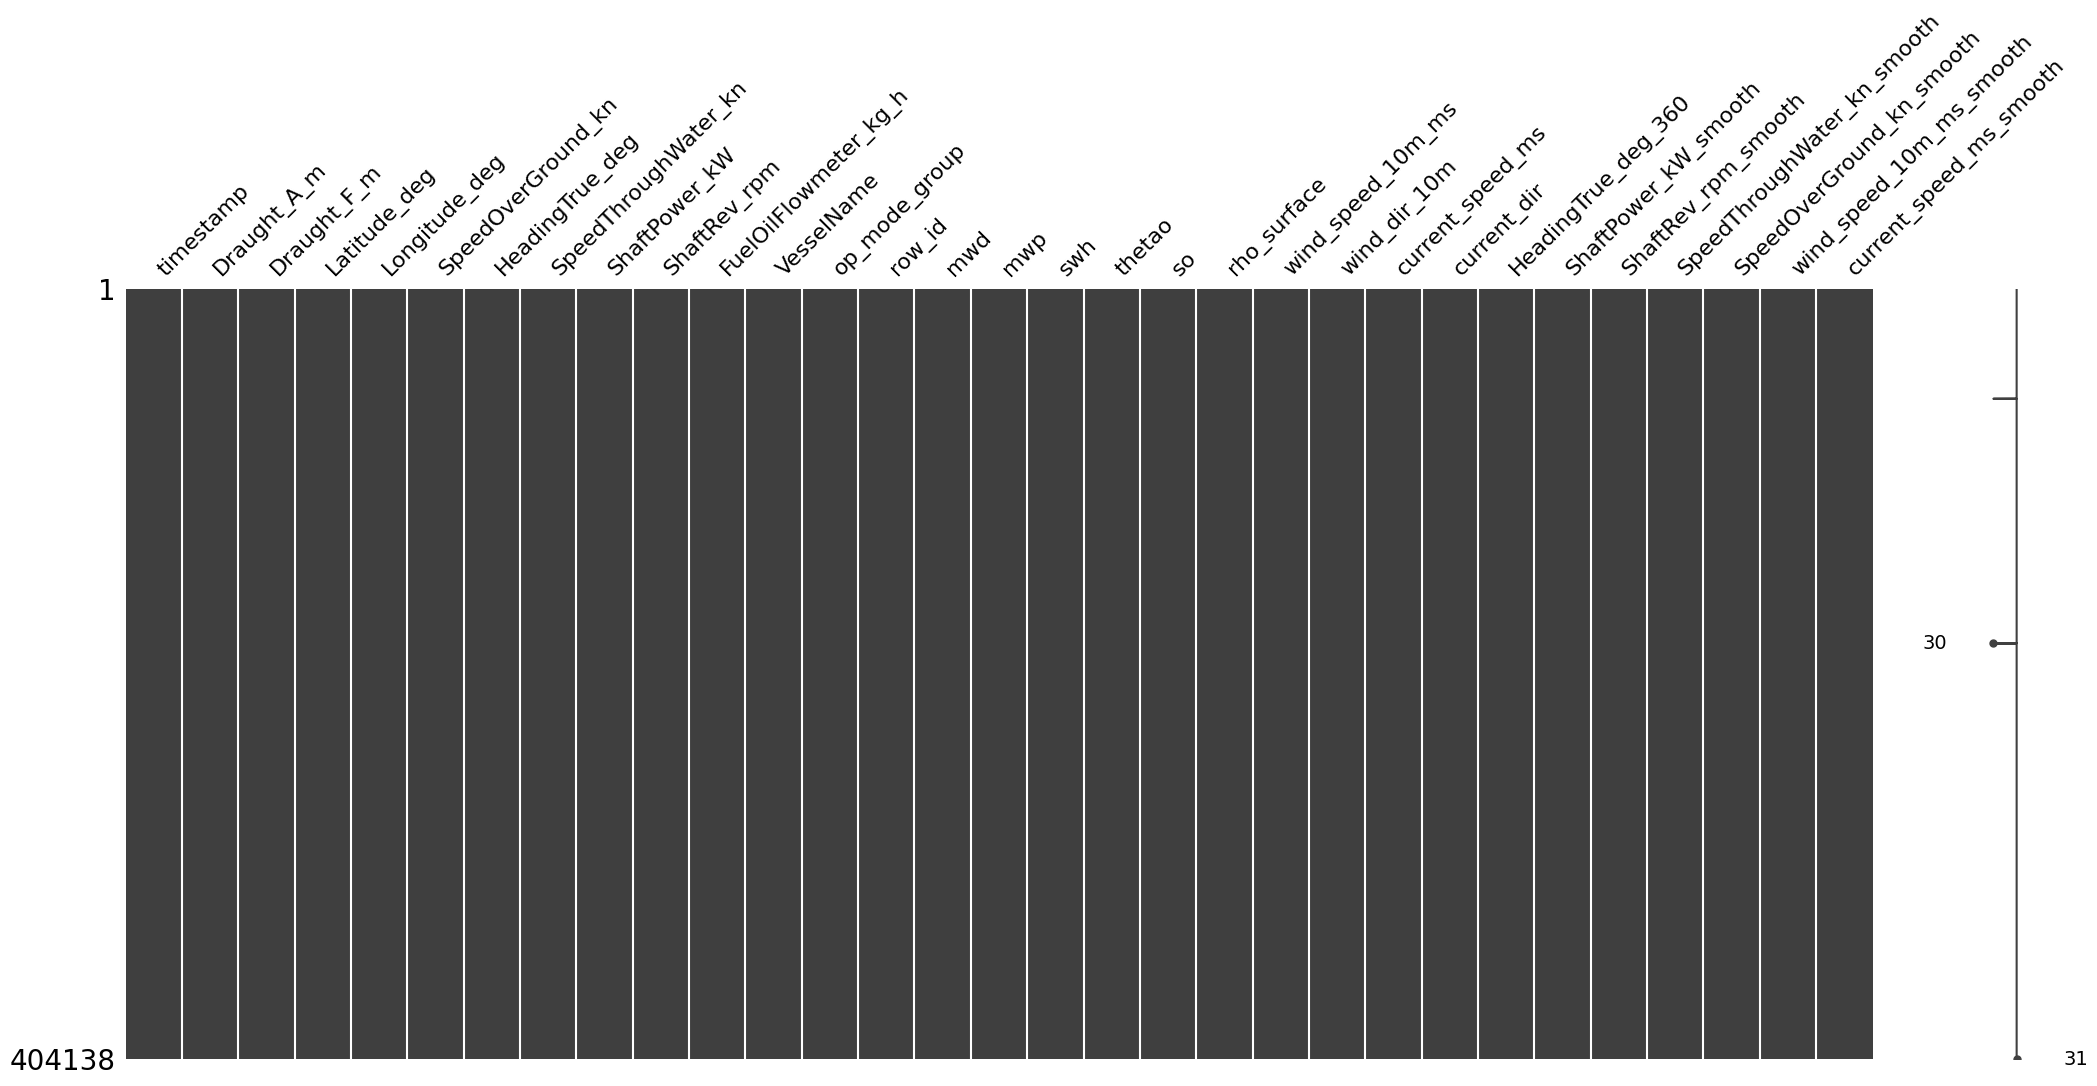

In [29]:
import missingno as msno

msno.matrix(df)

